In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn_extra.cluster import KMedoids
from sklearn.utils import shuffle
from bnn import BinarizedNetwork
from itertools import chain
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random, time, os, math

C:\Users\andre\anaconda3\envs\bnn\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\andre\anaconda3\envs\bnn\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\andre\anaconda3\envs\bnn\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\andre\anaconda3\envs\bnn\lib\site-packages\tensorflow\python\framework

# Dataset MNIST

In [2]:
# Download dataset MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Divisione delle immagini per addestramento e validazione
X_train = X_train.reshape((60000, 28, 28, 1))
X_test = X_test.reshape((10000, 28, 28, 1))

In [3]:
# [PARAMETRI MODIFICABILI PER ESPERIMENTI]

# Numero di immagini per il training set fewshot learning 
n_images_per_class = 80

# Metodo di campionamento delle immagini di training
method = "km"

# Solver
solver = "gd_t"

# Numero di neuroni nei due hidden layer Es: (10,3) o (4,4)
# NOTA: il numero di hidden layer delle singole BNN e' fissato a 2. 
n_hidden_units_h1 = 10
n_hidden_units_h2 = 3

# Architettura delle singole reti BNN(i,j)
n_input_units = 28*28
net = [n_input_units] + [n_hidden_units_h1] + [n_hidden_units_h2] + [1]

# Numero immagini test set delle singole reti BNN(i,j)
n_test_imgs = 800

# Tempo di training per ogni BNN(i,j) [m]
t_time = 120/45

# Learining rate
l_rate = 1e-3

In [4]:
# Funzione per la creazione del dataset per il training delle BNN.
# Input: X_train, immagini del training set
#        y_train, label del training set
#        imgs_per_class, numero di immagini per classe da campionare
#        method, kMethoids o campionamento casuale
# Output: dizionario con k immagini per classe ottenute tramite KMedoids k=10
# Es. data = {0: [img0_1, ..., img0_10], 9: [img9_1, ..., img9_10]}

def get_training_images(X_train, y_train, imgs_per_class, method):
    # Calcolo del numero di classi 
    classes = np.unique(y_train)

    # Creazione dizionario del dataset
    # Ad ogni classe corrisponde una lista di imgs_per_class immagini 
    data = dict.fromkeys(classes)

    for k in data.keys():
        train_filter = np.where(y_train == k)[0]
        training_imgs, training_lbls = X_train[train_filter[0:]], y_train[train_filter[0:]]

        # Normalizzazione immagini del training set
        training_imgs = training_imgs.astype(np.float32) / 255
        training_imgs = training_imgs.reshape(len(training_imgs), -1)

        if method == "km":
            # Ricerca delle immagini rappresentative per ogni classe con kMedoids
            kmedoids = KMedoids(n_clusters=imgs_per_class).fit(training_imgs) 
            images = kmedoids.cluster_centers_
        
        elif method == "r":
            # Campionamento casuale delle immagini rappresentative per ogni classe
            indices = np.random.randint(len(training_lbls), size=imgs_per_class)
            images = training_imgs[indices]
            
        else: 
            print("Errore!")
            break

        # Reshape centroidi in immagni
        images = images.reshape(imgs_per_class, 28, 28)
        images *= 255
        images = images.astype(np.uint8)

        # Memorizzazione dei centroidi nel dizionario 
        data[k] = images

        print(f"Class: {k} - Ok")

    return data

In [5]:
# Ricerca delle immagini rappresentive tramite KMedoids
data = get_training_images(X_train, y_train, n_images_per_class, method)

Class: 0 - Ok
Class: 1 - Ok
Class: 2 - Ok
Class: 3 - Ok
Class: 4 - Ok
Class: 5 - Ok
Class: 6 - Ok
Class: 7 - Ok
Class: 8 - Ok
Class: 9 - Ok


In [6]:
# Funzione per la creazione del dataset per il test delle BNN.
# Input: X_test, immagini del test set
#        y_test, label del test set
# Output: dizionario dataset iniziale
# Es. data = {0: [img0_1, ..., img0_n], 9: [img9_1, ..., img9_n]}

def get_testing_images(X_test, y_test):
    # Calcolo del numero di classi 
    classes = np.unique(y_test)

    # Creazione dizionario del dataset
    test_data = dict.fromkeys(classes)

    for k in test_data.keys():
        test_filter = np.where(y_test == k)[0]
        testing_imgs, testing_lbls = X_test[test_filter[0:]], y_test[test_filter[0:]]

        # Normalizzazione immagini del training set
        testing_imgs = testing_imgs.astype(np.float32) / 255

        test_data[k] = testing_imgs

    return test_data  

In [7]:
# Creazione dizionario con immagini di test
testing_data = get_testing_images(X_test, y_test)

In [8]:
# Funzione per visualizza le immagini rappresentative di ogni classe.
# Input: dataset, dizionaro del dataset ottenuto da get_training_images o get_testing_images
#        set_name, stringa per indicare training set o test set
#        lbls, eventuali label delle immagini

def plot_data(data, set_name, lbls=None, pred=None):
    if lbls is None:
        fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 1.5))
        fig.suptitle(f"{set_name} images", fontsize=16)
        for ax, image in zip(axes, data):
            ax.set_axis_off()
            image = image.reshape(28, 28)
            ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    else:
        fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))
        fig.suptitle(f"{set_name} images", fontsize=16)
        for ax, image, label in zip(axes, data, lbls):
            ax.set_axis_off()
            image = image.reshape(28, 28)
            ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
            if pred is not None:
                ax.set_title(f"Pred: {label}")
            else:
                ax.set_title(f"Label: {label}")

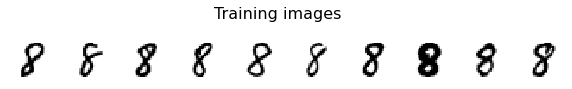

In [9]:
# Plot immagini di training per una specifica classe
plot_data(data[8], "Training")

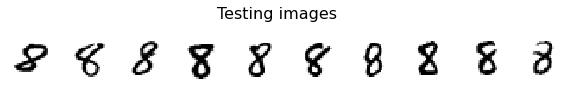

In [10]:
# Plot immagini di test per una specifica classe
plot_data(testing_data[8], "Testing")

In [11]:
# Funzione per la creazione del dataset per il training della rete neurale.
# Input: dataset, dizionaro del dataset ottenuto da get_training_images o get_testing_images
#        print_shape, parametro per stampa dimensioni di immagini e label
#        i & j, classi da estrarre dal dizionario per creare il training set
# Output: immagini e label del training set in ordine casuale

def get_shuffled_training_data(data, i, j, imgs_per_class, print_shape=False):
    training_imgs = np.concatenate((data[i], data[j]))
    training_lbls = np.concatenate(([i] * imgs_per_class, [j] * imgs_per_class))

    # Shuffle del training set
    training_imgs, training_lbls = shuffle(training_imgs, training_lbls)
    training_imgs = training_imgs.reshape(len(training_imgs), 28, 28, 1)

    if print_shape == True:
        print(f"Training images shape: {training_imgs.shape}, n: {len(training_imgs)}\n")
        print(f"Training labels shape: {training_lbls.shape}, n: {len(training_lbls)}\n")
        
    return training_imgs, training_lbls

In [12]:
# Funzione per la creazione del dataset per il test della rete neurale.
# Input: dataset, dizionaro del dataset ottenuto da get_training_images o get_testing_images
#        print_shape, parametro per stampa dimensioni di immagini e label
#        i & j, classi da estrarre dal dizionario per creare il training set
#        n_test_imgs, numero di immagini di test da usare (per classe)
# Output: immagini e label del training set in ordine casuale 

def get_shuffled_testing_data(testing_data, i, j, n_test_imgs, print_shape=False):
    testing_imgs = np.concatenate((testing_data[i][:n_test_imgs], testing_data[j][:n_test_imgs]))
    testing_lbls = np.concatenate(([i] * n_test_imgs, [j] * n_test_imgs))

    # Shuffle del test set
    testing_imgs, testing_lbls = shuffle(testing_imgs, testing_lbls)

    if print_shape == True:
        print(f"Testing images shape: {testing_imgs.shape}, n: {len(testing_imgs)}\n")
        print(f"Testing labels shape: {testing_lbls.shape}, n: {len(testing_lbls)}\n")
        
    return testing_imgs, testing_lbls

In [13]:
# Funzione per la creazione del dataset per il test della rete neurale.
# Input: dataset, dizionaro del dataset ottenuto da get_training_images o get_testing_images
#        print_shape, parametro per stampa dimensioni di immagini e label
# # Output: immagini e label del training set in ordine casuale 

def get_shuffled_ensemble_testing_data(testing_data, n_test_imgs, print_shape=False):
    for k in testing_data.keys():
        testing_data[k] = testing_data[k][:n_test_imgs]

    testing_imgs = np.array(list(chain.from_iterable(testing_data.values())))
    testing_lbls = np.array(list([key] * len(testing_data[key]) for key in testing_data.keys()))
    testing_lbls = testing_lbls.flatten()

    # Shuffle del test set
    testing_imgs, testing_lbls = shuffle(testing_imgs, testing_lbls)

    if print_shape == True:
        print(f"Testing images shape: {testing_imgs.shape}, n: {len(testing_imgs)}\n")
        print(f"Testing labels shape: {testing_lbls.shape}, n: {len(testing_lbls)}\n")
        
    return testing_imgs, testing_lbls

In [14]:
# Funzione per convertire le immagini di training e testing in array (dim=784).
# Input: dataset, training o test dataset
#        print_shape, parametro per stampa dimensioni di immagini e label
# Output: images, immagini in vettore 

def flatten_data(dataset, print_shape=False):
    images = np.zeros((len(dataset), 28*28), dtype=np.float32)

    for i in range(len(dataset)):
        images[i, :] = dataset[i].flatten().astype(np.float32)

    if print_shape == True: print(f"Shape: {images.shape}\n")
    
    return images    

# BeMi Ensemble

In [15]:
# Funzione per one_hot encoding delle label
def get_one_hot_encoding(labels, i, j):
    encoder = LabelEncoder()
    encoder.fit([i, j])
    transformed_labels = np.array([encoder.transform(labels)]).T
    
    return transformed_labels

# Funzione per il test della rete naurale
# Input: net, architetture della rete binarizzata da testare
#        weights, pesi della rete binarizzata salvati su file
#        biases, bias della rete binarizzata salvati su file
#        train_data, immagini per il training della rete neurale
#        train_labels, label delle immagini per il training della rete neurale
#        test_data, immagini per il test della rete neurale
#        test_labels, label delle immagini per il test della rete neurale
# Output: train_performance,
#         test_performance, 

def test_weights(net, weights, biases, images, labels, timages, tlabels):
    bnn = BinarizedNetwork(net)
    a = np.unique(tlabels)[0]
    b = np.unique(tlabels)[1]
    for i in range(len(weights)):
        bnn.update_layer(i, weights[i], biases[i])
    train_performance = bnn.test_network(images, labels)
    tlabels =  2.0*get_one_hot_encoding(tlabels, a, b) - 1.0 # mapping labels to -1/1 vectors
    test_performance = bnn.test_network(timages, tlabels)
    
    # clossing the network sessions
    bnn.close()

    return train_performance, test_performance

In [16]:
# Funzione per il salvataggio delle informazioni della rete addestrata.
# Input: solver, metodo di quantizzazione dei pesi
#        tf_seed, parametro inizializzazione dei pesi
#        lr, learning rate
#        info, performance del training e test set, pesi quantizzati
# Output: file .txt con info complete, file con array dei pesi e dei bias

def _save_gd_results(solver, tf_seed, lr, info, training_imgs, training_lbls):
    # Salvataggio di pesi e bias
    folder_out = "../results/ensemble/%s/%s/%s/%s/"%(solver, info["arch"], info["t_method"], info["k_train"])
    log_rl = -round(math.log(lr,10))
    file_out = folder_out + info["name"] + "_" + info["arch"] + "_" + info["k_train"] + ".txt"
    if not os.path.exists(folder_out):
        os.makedirs(folder_out)
    f = open(file_out,"w")
    f.write("solver=%s\n"%solver)
    for k in info:
        if k == "weights":
            info[k] = [w.tolist() for w in info[k]]
        if k == "biases":
            info[k] = [b.tolist() for b in info[k]]
        f.write(k+"="+str(info[k])+"\n")
    f.close()
    
    file_out = folder_out + info["name"] + "_" + info["arch"] + "_" + info["k_train"] + ".npz"
    with open(file_out, "wb") as file:
        np.savez(file, w0=info["weights"][0], w1=info["weights"][1], w2=info["weights"][2],
                       b0=info["biases"][0], b1=info["biases"][1], b2=info["biases"][2])  
    
    # Salvataggio delle immagini del training set
    folder_out = "../mnist/%s/%s"%(info["t_method"], info["k_train"])
    if not os.path.exists(folder_out):
        os.makedirs(folder_out)
    
    if len(os.listdir(folder_out)) != 90:
        if info["t_method"] == "km":
            ts = "training_set_"
            ls = "labels_"
        else: 
            ts = "r_training_set_"
            ls = "r_labels_"

        file_out = "../mnist/" + info["t_method"] + "/" + info["k_train"]  + "/" + ts + info["name"] + "_" + info["k_train"] + ".npz"
        with open(file_out, "wb") as file:
            args_list = ["img" + str(i) for i in range(len(training_imgs))]
            imgs_dict = dict(zip(args_list, training_imgs))
            np.savez(file, **imgs_dict) 
            
        file_out = "../mnist/" + info["t_method"] + "/" + info["k_train"]  + "/" + ls + info["name"] + "_" + info["k_train"] + ".npy"
        with open(file_out, "wb") as file:
            np.save(file, training_lbls)

In [17]:
# Funzione per creazione, training e test di una Rete Neurale Binarizzata.
# Input: solver, metodo per binarizzazione
#               "gd_b": gradient descend using binary weights  (-1,1)
#               "gd_t": gradient descend using ternary weights (-1,0,1)
#        lr, learning rate
#        tf_seed, parametro inizializzazione rete neurale
#        n_hidden_units_h1, numero neuroni 1 hidden layer
#        n_hidden_units_h2, numero neuroni 2 hidden layer
#        train_data, immagini per il training della rete neurale
#        train_labels, label delle immagini per il training della rete neurale
#        test_data, immagini per il test della rete neurale
#        test_labels, label delle immagini per il test della rete neurale
#        time_out, tempo limite per il training della rete neurale [min]
# Output: file con i dati relativi alla rete 

def ctt_small_bnn(solver, lr, tf_seed, n_hidden_units_h1, n_hidden_units_h2, train_data, train_labels, test_data, test_labels, t_method, time_out):

    a = np.unique(train_labels)[0]
    b = np.unique(train_labels)[1]
    
    print(f"Small BNN {str(a)}/{str(b)}")

    # Setting the network's architecture
    n_input_units   = 28*28
    n_output_units  = 1
    net = [28*28] + [n_hidden_units_h1, n_hidden_units_h2] + [1]
    
    # Original labels
    original_labels = train_labels

    # Get one-hot encoding for training labels
    train_labels = get_one_hot_encoding(train_labels, a, b)

    # Training and testing the net
    from gd.gd_baseline_mod import StandardNeuralNet
    nn = StandardNeuralNet(solver, n_input_units, n_hidden_units_h1, n_hidden_units_h2, n_output_units, lr, tf_seed)
    start = time.time()
    is_sat = nn.train(train_data, train_labels, train_data, train_labels, time_out)
    total_time = ((time.time()-start)/60.0)
    
    # Testing the solution (weights of dead neurons are set to zero here)
    weights, biases = nn.get_weights()
    
    dead_inputs = np.all(train_data == train_data[0,:], axis = 0)
    for neuron_in in range(n_input_units):
        if dead_inputs[neuron_in]: weights[0][neuron_in,:] = np.zeros(net[1])
    train_performance, test_performance = test_weights(net, weights, biases, train_data, 2*train_labels-1, test_data, test_labels)
    print(" Total time = %0.2f[m]"%total_time)
    print(" Train performance = %0.4f"%train_performance)
    print(" Test performance = %0.4f"%test_performance)
    
    # Salvataggio delle info
    info = {}
    info["name"] = "bnn" + str(a) + str(b)
    info["arch"] = str(n_hidden_units_h1) + "_" + str(n_hidden_units_h2) 
    info["lr"] = lr
    info["tf_seed"] = tf_seed
    info["train_performance"] = train_performance
    info["test_performance"] = test_performance
    info["total_time"] = total_time
    info["is_sat"] = (train_performance == 1.0)
    info["weights"] = weights #[w.tolist() for w in weights]
    info["biases"] = biases #[b.tolist() for b in biases]
    info["k_train"] = str(round(len(train_labels)/2))
    info["t_method"] = t_method
    _save_gd_results(solver, tf_seed, lr, info, train_data, original_labels)
    
    # clossing the network sessions
    nn.close()

    print("-----------------------------\n")

In [18]:
# Funzione per la lettura di pesi e bias di una singola BNN.
# Input: solver, metodo di binarizzazione
#        i & j indici della singola rete addestrata
#        arch, tupla contenente il numero di unita dei due hidden layer, es. (10,3)
# Ouput: w, pesi della rete (i,j)
#        b, bias della rete (i,j)
#        training_imgs, immagini training set con cui e' stata addestrata la rete (i,j)

def load_small_bnn(solver, i, j, arch, t_method, imgs_per_class):
    # Lettuara da file di pesi e bias
    folder_out = "../results/ensemble/%s/%d_%d/%s/%d/"%(solver, arch[0], arch[1], t_method, imgs_per_class)
    file_out = folder_out + "bnn%d%d_%d_%d_%d.npz"%(i, j, arch[0], arch[1], imgs_per_class)
    with open(file_out, "rb") as file:
        nn_data = np.load(file, allow_pickle=True)
        w = [nn_data["w0"], nn_data["w1"], nn_data["w2"]]
        b = [nn_data["b0"], nn_data["b1"], nn_data["b2"]]
    
    # Lettura da file delle immagini del training set
    folder_out = "../mnist/%s/%d"%(t_method, imgs_per_class)
    if t_method == "km": 
        ts = "training_set"
    else :
        ts = "r_training_set"
        
    file_out = "../mnist/%s/%d/%s_bnn%d%d_%d.npz"%(t_method, imgs_per_class, ts, i, j, imgs_per_class)
    with open(file_out, "rb") as file:
        training_data = np.load(file, allow_pickle=True)
        training_imgs = np.array([img for img in training_data.values()])

    return w, b, training_imgs

In [19]:
def load_training_data(i, j, t_method, imgs_per_class):
    folder_out = "../mnist/%s/%d"%(t_method, imgs_per_class)
    if t_method == "km":
        ts = "training_set"
        ls = "labels"
    else: 
        ts = "r_training_set"
        ls = "r_labels"
        
    file_out = "../mnist/%s/%d/%s_bnn%d%d_%d.npz"%(t_method, imgs_per_class, ts, i, j, imgs_per_class)
    with open(file_out, "rb") as file:
        training_data = np.load(file, allow_pickle=True)
        training_imgs = np.array([img for img in training_data.values()])
        
    file_out = "../mnist/%s/%d/%s_bnn%d%d_%d.npy"%(t_method, imgs_per_class, ls, i, j, imgs_per_class)
    with open(file_out, "rb") as file:
        training_lbls = np.load(file, allow_pickle=True)    
    
    return training_imgs, training_lbls

In [20]:
# Funzione per ottenere le predizioni di una singola BNN.
# Input: i,j indici della singola rete addestrata
#        weights, pesi della rete (i,j) addestrata
#        biases, bias della rete (i,j) addestrata
#        n_input_units, numero dei neuroni di input
#        training_data, immagini di training
#        test_data, immagini di test
# Output: predicted_labels, vettore delle label predette
#         links_stats, tupla con link tra neuroni e dimensioni effettive della rete

def small_bnn_predict(i, j, weights, biases, n_input_units, training_data, test_data):
    dead_inputs = np.all(training_data == training_data[0,:], axis = 0)
    for neuron_in in range(n_input_units):
        if dead_inputs[neuron_in]: weights[0][neuron_in,:] = np.zeros(net[1])

    bnn = BinarizedNetwork(net)
    for k in range(len(weights)):
        bnn.update_layer(k, weights[k], biases[k])

    predictions = np.squeeze(bnn.get_activations(test_data)[3])
    oh_predictions = (1 + predictions) / 2
    
    predicted_labels = []
    
    for k in oh_predictions:
        if k == 0:
            predicted_labels.append(i)
        else:
            predicted_labels.append(j)
            
    
    return predicted_labels

In [21]:
folder_out = "../results/ensemble/%s/%d_%d/%s/%d/"%(solver, n_hidden_units_h1, n_hidden_units_h2, method, n_images_per_class)
if not os.path.exists(folder_out):
    os.makedirs(folder_out)

if len(os.listdir("../results/ensemble/%s/%d_%d/%s/%d"%(solver, n_hidden_units_h1, n_hidden_units_h2, method, n_images_per_class))) == 0:
    folder_out = "../mnist/%s/%d"%(method, n_images_per_class)
    if not os.path.exists(folder_out):
        print(f"[New training set: method={method}, k={n_images_per_class}]")
        for i in range(10):
            for j in range(i+1, 10):
                # Creazione training set 
                training_imgs, training_lbls = get_shuffled_training_data(data, i, j, n_images_per_class)
                training_imgs = flatten_data(training_imgs)


                # Creazione test set 
                testing_imgs, testing_lbls = get_shuffled_testing_data(testing_data, i, j, n_test_imgs)
                testing_imgs = flatten_data(testing_imgs)

                # Creazione, training e test delle singolo BNN 
                ctt_small_bnn(solver, l_rate, 0, n_hidden_units_h1, n_hidden_units_h2, training_imgs, training_lbls, testing_imgs, testing_lbls, method, t_time)
    else:
        print(f"[Loading existing training set: method={method}, k={n_images_per_class}]")
        for i in range(10):
            for j in range(i+1, 10):
                # Caricamento del training set
                training_imgs, training_lbls = load_training_data(i, j, method, n_images_per_class)
                training_lbls = np.ravel(training_lbls)
                
                # Creazione test set 
                testing_imgs, testing_lbls = get_shuffled_testing_data(testing_data, i, j, n_test_imgs)
                testing_imgs = flatten_data(testing_imgs)

                # Creazione, training e test delle singolo BNN 
                ctt_small_bnn(solver, l_rate, 0, n_hidden_units_h1, n_hidden_units_h2, training_imgs, training_lbls, testing_imgs, testing_lbls, method, t_time)
                

In [22]:
# Creazione test set per l'ensemble di BNN
testing_imgs, testing_lbls = get_shuffled_ensemble_testing_data(testing_data, n_test_imgs)
testing_imgs = flatten_data(testing_imgs)

#testing_imgs = testing_imgs[:100]
#testing_lbls = testing_lbls[:100]

In [23]:
# Matrice con label predette dalle 45 BNN.
# Ogni singola BNN e' testata su 10 immagini.
small_bnn_predictions = np.zeros((45, len(testing_imgs)))

# Caricamento delle BNN pre-trained e inferenza su test set
k = 0
for i in range(10):
    for j in range(i+1, 10):
        weights, biases, training_imgs = load_small_bnn(solver, i, j, (n_hidden_units_h1, n_hidden_units_h2), method, n_images_per_class)
        small_bnn_predictions[k, :] = small_bnn_predict(i, j, weights, biases, n_input_units, training_imgs, testing_imgs)
        print(f"Small BNN {i}/{j} - Ok")
        k = k + 1

Small BNN 0/1 - Ok
Small BNN 0/2 - Ok
Small BNN 0/3 - Ok
Small BNN 0/4 - Ok
Small BNN 0/5 - Ok
Small BNN 0/6 - Ok
Small BNN 0/7 - Ok
Small BNN 0/8 - Ok
Small BNN 0/9 - Ok
Small BNN 1/2 - Ok
Small BNN 1/3 - Ok
Small BNN 1/4 - Ok
Small BNN 1/5 - Ok
Small BNN 1/6 - Ok
Small BNN 1/7 - Ok
Small BNN 1/8 - Ok
Small BNN 1/9 - Ok
Small BNN 2/3 - Ok
Small BNN 2/4 - Ok
Small BNN 2/5 - Ok
Small BNN 2/6 - Ok
Small BNN 2/7 - Ok
Small BNN 2/8 - Ok
Small BNN 2/9 - Ok
Small BNN 3/4 - Ok
Small BNN 3/5 - Ok
Small BNN 3/6 - Ok
Small BNN 3/7 - Ok
Small BNN 3/8 - Ok
Small BNN 3/9 - Ok
Small BNN 4/5 - Ok
Small BNN 4/6 - Ok
Small BNN 4/7 - Ok
Small BNN 4/8 - Ok
Small BNN 4/9 - Ok
Small BNN 5/6 - Ok
Small BNN 5/7 - Ok
Small BNN 5/8 - Ok
Small BNN 5/9 - Ok
Small BNN 6/7 - Ok
Small BNN 6/8 - Ok
Small BNN 6/9 - Ok
Small BNN 7/8 - Ok
Small BNN 7/9 - Ok
Small BNN 8/9 - Ok


In [24]:
# Majority Voting
# Vettore con le predizioni dell'ensemble
ensemble_predictions = []
voting_register = [0, 0, 0, 0, 0, 0, 0]
voting_status = []

# Voting per ogni immagine
for k in range(len(testing_imgs)):
    labels, votes = np.unique(small_bnn_predictions[:,k], return_counts=True)
    single_img_votes = dict(zip(labels, votes))
    maximum = np.amax([n for n in single_img_votes.values()])
    max_count = []
    for i in single_img_votes.keys():
        if single_img_votes[i] == maximum:
            max_count.append((i, single_img_votes[i]))

    if len(max_count) == 1:
        ensemble_predictions.append(max_count[0][0])
        if max_count[0][0] == testing_lbls[k]:
            status = 0
            voting_register[0] += 1
        else:
            status = 6
            voting_register[6] += 1
    elif len(max_count) == 2:
        i = max_count[0][0]
        j = max_count[1][0]
        bnns = {}
        nn = 0 
        for ii in range(10):
            for jj in range(ii+1, 10):
                bnns[(ii, jj)] = nn
                nn = nn + 1
        ensemble_predictions.append(small_bnn_predictions[bnns[(i,j)], k])
        if small_bnn_predictions[bnns[(i,j)], k] == testing_lbls[k]:
            status = 1
            voting_register[1] += 1
        elif j == testing_lbls[k]:
            status = 2
            voting_register[2] += 1
        else: 
            status = 5
            voting_register[5] += 1
    else:
        ensemble_predictions.append(-1)
        
        flag = 0
        for i in range(len(max_count)):
            if max_count[i][0] == testing_lbls[k]:
                flag += 1
        if flag >= 1:
            status = 3
            voting_register[3] += 1
        else:
            status = 4
            voting_register[4] += 1
        
    voting_status.append(status)
        
ensemble_predictions = [int(p) for p in ensemble_predictions]

In [25]:
print("[ENSEMBLE STATS] \n")
correct_predictions = np.sum(ensemble_predictions == testing_lbls)
print(f"Num. immagini correttamente classificate dall'ensemble: {correct_predictions}/{len(testing_lbls)}, {(correct_predictions/len(testing_lbls))*100:.3f} %")

misclassified_predictions = len(testing_lbls) - correct_predictions - sum(abs(i) for i in ensemble_predictions if i == -1)  
print(f"Num. immagini non correttamente classificate dall'ensemble: {misclassified_predictions}/{len(testing_lbls)}, {(misclassified_predictions/len(testing_lbls))*100:.3f} %")

non_labeld_predictions = sum(abs(i) for i in ensemble_predictions if i == -1)
print(f"Num. immagini non classificate dall'ensemble: {non_labeld_predictions}/{len(testing_lbls)}, {(non_labeld_predictions/len(testing_lbls))*100:.3f} %\n")

print(f"[VOTING REGISTER]\n")
i = 0
for j in voting_register:
    print(f"Status: {i} - {j/len(testing_lbls)*100:.3f} %")
    i += 1

print("\n[CLASSIFICATION RESULTS]\n")
print("0 = there was one maximum value and the label was correct")
print("1 = there were two maximum values and the label was correct")
print("2 = there were two maximum values, the label was not the one given but the other one")
print("3 = there were more than three maximum value and one of these was correct")
print("4 = there were more than three maximum values, all wrong")
print("5 = there were two maximum values, both wrong")
print("6 = there was one maximum value and the label was wrong\n")

for i in range(len(testing_lbls)):
    print(f"True label: {testing_lbls[i]}, Predicted: {ensemble_predictions[i]}, Voting status: {voting_status[i]}")

[ENSEMBLE STATS] 

Num. immagini correttamente classificate dall'ensemble: 2525/8000, 31.562 %
Num. immagini non correttamente classificate dall'ensemble: 4583/8000, 57.288 %
Num. immagini non classificate dall'ensemble: 892/8000, 11.150 %

[VOTING REGISTER]

Status: 0 - 24.925 %
Status: 1 - 6.638 %
Status: 2 - 1.675 %
Status: 3 - 7.462 %
Status: 4 - 3.688 %
Status: 5 - 15.637 %
Status: 6 - 39.975 %

[CLASSIFICATION RESULTS]

0 = there was one maximum value and the label was correct
1 = there were two maximum values and the label was correct
2 = there were two maximum values, the label was not the one given but the other one
3 = there were more than three maximum value and one of these was correct
4 = there were more than three maximum values, all wrong
5 = there were two maximum values, both wrong
6 = there was one maximum value and the label was wrong

True label: 1, Predicted: 1, Voting status: 0
True label: 8, Predicted: 8, Voting status: 1
True label: 6, Predicted: 9, Voting statu

True label: 5, Predicted: -1, Voting status: 3
True label: 4, Predicted: 9, Voting status: 6
True label: 4, Predicted: 8, Voting status: 6
True label: 5, Predicted: 8, Voting status: 6
True label: 6, Predicted: 9, Voting status: 6
True label: 6, Predicted: -1, Voting status: 3
True label: 1, Predicted: 8, Voting status: 6
True label: 1, Predicted: 1, Voting status: 0
True label: 0, Predicted: -1, Voting status: 3
True label: 2, Predicted: -1, Voting status: 4
True label: 1, Predicted: 1, Voting status: 0
True label: 9, Predicted: 7, Voting status: 2
True label: 0, Predicted: 7, Voting status: 5
True label: 2, Predicted: -1, Voting status: 4
True label: 3, Predicted: 5, Voting status: 6
True label: 9, Predicted: 9, Voting status: 0
True label: 0, Predicted: -1, Voting status: 3
True label: 4, Predicted: 9, Voting status: 6
True label: 8, Predicted: 8, Voting status: 1
True label: 7, Predicted: 9, Voting status: 5
True label: 5, Predicted: 8, Voting status: 6
True label: 7, Predicted: 7,

True label: 7, Predicted: 7, Voting status: 0
True label: 7, Predicted: 8, Voting status: 6
True label: 4, Predicted: 9, Voting status: 6
True label: 4, Predicted: 4, Voting status: 0
True label: 7, Predicted: -1, Voting status: 4
True label: 2, Predicted: -1, Voting status: 4
True label: 7, Predicted: 7, Voting status: 0
True label: 4, Predicted: -1, Voting status: 4
True label: 9, Predicted: 4, Voting status: 6
True label: 0, Predicted: -1, Voting status: 3
True label: 4, Predicted: 8, Voting status: 5
True label: 6, Predicted: 6, Voting status: 0
True label: 0, Predicted: -1, Voting status: 3
True label: 7, Predicted: 7, Voting status: 0
True label: 1, Predicted: 5, Voting status: 6
True label: 6, Predicted: 0, Voting status: 6
True label: 9, Predicted: 9, Voting status: 0
True label: 6, Predicted: 8, Voting status: 6
True label: 2, Predicted: 4, Voting status: 6
True label: 3, Predicted: 0, Voting status: 6
True label: 4, Predicted: 9, Voting status: 6
True label: 4, Predicted: 7, 

True label: 5, Predicted: 8, Voting status: 6
True label: 1, Predicted: 8, Voting status: 5
True label: 6, Predicted: 4, Voting status: 6
True label: 1, Predicted: -1, Voting status: 3
True label: 2, Predicted: -1, Voting status: 4
True label: 6, Predicted: 7, Voting status: 6
True label: 3, Predicted: 8, Voting status: 6
True label: 4, Predicted: 7, Voting status: 5
True label: 4, Predicted: 9, Voting status: 5
True label: 8, Predicted: 8, Voting status: 0
True label: 3, Predicted: 3, Voting status: 1
True label: 0, Predicted: -1, Voting status: 3
True label: 6, Predicted: 8, Voting status: 6
True label: 3, Predicted: 5, Voting status: 6
True label: 3, Predicted: 3, Voting status: 0
True label: 3, Predicted: 5, Voting status: 6
True label: 2, Predicted: 9, Voting status: 5
True label: 3, Predicted: 5, Voting status: 5
True label: 0, Predicted: 0, Voting status: 0
True label: 3, Predicted: 3, Voting status: 1
True label: 2, Predicted: 8, Voting status: 5
True label: 4, Predicted: -1, V

True label: 4, Predicted: -1, Voting status: 4
True label: 3, Predicted: 3, Voting status: 0
True label: 3, Predicted: 8, Voting status: 5
True label: 5, Predicted: 8, Voting status: 6
True label: 2, Predicted: 8, Voting status: 6
True label: 4, Predicted: 4, Voting status: 1
True label: 0, Predicted: 0, Voting status: 0
True label: 6, Predicted: 4, Voting status: 2
True label: 7, Predicted: 7, Voting status: 0
True label: 9, Predicted: 0, Voting status: 6
True label: 7, Predicted: 7, Voting status: 0
True label: 6, Predicted: 2, Voting status: 6
True label: 5, Predicted: 5, Voting status: 0
True label: 2, Predicted: 2, Voting status: 0
True label: 8, Predicted: 3, Voting status: 2
True label: 7, Predicted: 5, Voting status: 6
True label: 9, Predicted: 8, Voting status: 6
True label: 0, Predicted: 0, Voting status: 0
True label: 8, Predicted: 8, Voting status: 0
True label: 0, Predicted: -1, Voting status: 3
True label: 3, Predicted: 3, Voting status: 1
True label: 7, Predicted: 9, Vot

True label: 6, Predicted: 5, Voting status: 5
True label: 2, Predicted: 8, Voting status: 6
True label: 4, Predicted: 0, Voting status: 6
True label: 8, Predicted: 8, Voting status: 1
True label: 9, Predicted: 5, Voting status: 2
True label: 0, Predicted: 0, Voting status: 0
True label: 1, Predicted: 8, Voting status: 5
True label: 8, Predicted: 3, Voting status: 6
True label: 6, Predicted: 8, Voting status: 6
True label: 0, Predicted: 5, Voting status: 5
True label: 7, Predicted: 7, Voting status: 0
True label: 7, Predicted: 9, Voting status: 6
True label: 3, Predicted: 5, Voting status: 6
True label: 8, Predicted: -1, Voting status: 3
True label: 1, Predicted: 9, Voting status: 5
True label: 8, Predicted: 8, Voting status: 0
True label: 9, Predicted: 9, Voting status: 1
True label: 6, Predicted: 3, Voting status: 6
True label: 2, Predicted: 0, Voting status: 2
True label: 6, Predicted: -1, Voting status: 3
True label: 8, Predicted: 8, Voting status: 1
True label: 5, Predicted: 4, Vot

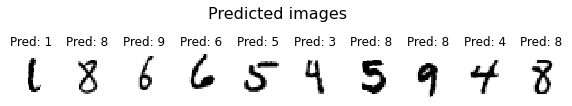

In [26]:
plot_data(testing_imgs, "Predicted", ensemble_predictions, pred=True)

In [27]:
# Calcolo delle statistiche di ogni rete BNN
stats = []
nn = 0

for i in range(10):
    for j in range(i+1, 10):
        
        # Singola BNN
        bnn_stats = {}
        bnn_stats["nn"] = "bnn" + str(i) + str(j) 
        
        # Calcolo del numero di immagini classificate correttamente
        bnn_stats["correct"] = np.sum(small_bnn_predictions[nn, :] == testing_lbls)
        
        # Calcolo del numero di immagni classificate non correttamente
        bnn_stats["misclassified"] = np.sum(small_bnn_predictions[nn, :] != testing_lbls)
        
        nn += 1
        stats.append(bnn_stats)

In [28]:
# Statistiche singole BNN
print("[SINGLE BNN STATS]\n")
for i in range(len(stats)):
    print(f"{stats[i]['nn']} - Correct: {stats[i]['correct']}, Misclassified: {stats[i]['misclassified']}")

[SINGLE BNN STATS]

bnn01 - Correct: 1295, Misclassified: 6705
bnn02 - Correct: 1062, Misclassified: 6938
bnn03 - Correct: 1202, Misclassified: 6798
bnn04 - Correct: 1195, Misclassified: 6805
bnn05 - Correct: 1043, Misclassified: 6957
bnn06 - Correct: 1234, Misclassified: 6766
bnn07 - Correct: 1128, Misclassified: 6872
bnn08 - Correct: 1115, Misclassified: 6885
bnn09 - Correct: 1379, Misclassified: 6621
bnn12 - Correct: 1084, Misclassified: 6916
bnn13 - Correct: 807, Misclassified: 7193
bnn14 - Correct: 1387, Misclassified: 6613
bnn15 - Correct: 1140, Misclassified: 6860
bnn16 - Correct: 1111, Misclassified: 6889
bnn17 - Correct: 1430, Misclassified: 6570
bnn18 - Correct: 918, Misclassified: 7082
bnn19 - Correct: 1112, Misclassified: 6888
bnn23 - Correct: 1160, Misclassified: 6840
bnn24 - Correct: 919, Misclassified: 7081
bnn25 - Correct: 1050, Misclassified: 6950
bnn26 - Correct: 1002, Misclassified: 6998
bnn27 - Correct: 1264, Misclassified: 6736
bnn28 - Correct: 874, Misclassified: 

# Large BNN

In [29]:
# Funzione per la creazione del dataset per il training della rete neurale.
# Input: dataset, dizionaro del dataset ottenuto da get_training_images o get_testing_images
#        print_shape, parametro per stampa dimensioni di immagini e label
# Output: immagini e label del training set in ordine casuale

def get_shuffled_training_data_large_bnn(data, n_imgs, print_shape=False):
    training_imgs = np.array(list(chain.from_iterable(data.values())))
    training_lbls = np.array([[keys] * n_imgs for keys in data.keys()]).flatten()

    # Shuffle del training set
    training_imgs, training_lbls = shuffle(training_imgs, training_lbls)
    training_imgs = training_imgs.reshape(len(training_imgs), 28, 28, 1)

    if print_shape == True:
        print(f"Training images shape: {training_imgs.shape}, n: {len(training_imgs)}\n")
        print(f"Training labels shape: {training_lbls.shape}, n: {len(training_lbls)}\n")
        
    return training_imgs, training_lbls

In [30]:
# Creazione training set 
training_imgs, training_lbls = get_shuffled_training_data_large_bnn(data, n_images_per_class)
training_imgs = flatten_data(training_imgs)

In [31]:
# Funzione per one_hot encoding delle label
def get_one_hot_encoding_large_bnn(a, n_classes=10):
    b = np.zeros((a.size, n_classes))
    b[np.arange(a.size), a] = 1
    return b

# Funzione per il test della rete naurale
# Input: net, architetture della rete binarizzata da testare
#        weights, pesi della rete binarizzata salvati su file
#        biases, bias della rete binarizzata salvati su file
#        train_data, immagini per il training della rete neurale
#        train_labels, label delle immagini per il training della rete neurale
#        test_data, immagini per il test della rete neurale
#        test_labels, label delle immagini per il test della rete neurale
# Output: train_performance,
#         test_performance, 

def test_weights_large_bnn(net, weights, biases, images, labels, timages, tlabels):
    bnn = BinarizedNetwork(net)
    for i in range(len(weights)):
        bnn.update_layer(i, weights[i], biases[i])
    train_performance = bnn.test_network(images, labels)
    #images, labels = get_mnist_test_numpy()
    tlabels =  2.0*get_one_hot_encoding_large_bnn(tlabels) - 1.0 # mapping labels to -1/1 vectors
    test_performance = bnn.test_network(timages, tlabels)

    # clossing the network sessions
    bnn.close()

    return train_performance, test_performance

In [32]:
def _save_gd_results_large_bnn(solver, time_out, tf_seed, lr, info):
    folder_out = "../results/large_bnn/%s/"%(solver)
    log_rl = -round(math.log(lr,10))
    file_out   = folder_out + "large_bnn_%d.txt"%info["imgs_per_class"]
    if not os.path.exists(folder_out):
        os.makedirs(folder_out)
    f = open(file_out,"w")
    f.write("solver=%s\n"%solver)
    f.write("time_out=%d\n"%time_out)
    for k in info:
        f.write(k+"="+str(info[k])+"\n")
    f.close()

In [33]:
# Funzione per creazione e test di una Rete Neurale Binarizzata.
# Input: solver, metodo per binarizzazione
#               "gd_b": gradient descend using binary weights  (-1,1)
#               "gd_t": gradient descend using ternary weights (-1,0,1)
#        lr, learning rate
#        tf_seed, parametro inizializzazione rete neurale
#        n_hidden_units_h1, numero neuroni 1 hidden layer
#        n_hidden_units_h2, numero neuroni 2 hidden layer
#        train_data, immagini per il training della rete neurale
#        train_labels, label delle immagini per il training della rete neurale
#        test_data, immagini per il test della rete neurale
#        test_labels, label delle immagini per il test della rete neurale
#        time_out, tempo limite per il training della rete neurale [min]

def ctt_large_bnn(solver, lr, tf_seed, n_hidden_units_h1, n_hidden_units_h2, train_data, train_labels, test_data, test_labels, time_out):

    print("[LARGE BNN STATS]\n")
    print(" Arch: [784, 128, 64, 10]")
    print(" Solver:", solver)
    print(" Time out:", time_out)
    print(" Learning rate:", lr)

    # Setting the network's architecture
    n_input_units   = 28*28
    n_output_units  = 10
    net = [28*28] + [n_hidden_units_h1, n_hidden_units_h2] + [10]

    # Get one-hot encoding for training labels
    train_labels = get_one_hot_encoding_large_bnn(train_labels)

    # Training and testing the net
    from gd.gd_baseline_mod import StandardNeuralNet
    nn = StandardNeuralNet(solver, n_input_units, n_hidden_units_h1, n_hidden_units_h2, n_output_units, lr, tf_seed)
    start = time.time()
    is_sat = nn.train(train_data, train_labels, train_data, train_labels, time_out)
    total_time = ((time.time()-start)/60.0)
    
    # Testing the solution (weights of dead neurons are set to zero here)
    weights, biases = nn.get_weights()
    
    dead_inputs = np.all(train_data == train_data[0,:], axis = 0)
    for neuron_in in range(n_input_units):
        if dead_inputs[neuron_in]: weights[0][neuron_in,:] = np.zeros(net[1])
    train_performance, test_performance = test_weights_large_bnn(net, weights, biases, train_data, 2*train_labels-1, test_data, test_labels)
    print("-----------------------------")
    print("Total time = %0.2f[m]"%total_time)
    print("Train performance = %0.4f"%train_performance)
    print("Test performance = %0.4f"%test_performance)
    
    # Salvataggio delle info
    info = {}
    info["lr"] = lr
    info["tf_seed"] = tf_seed
    info["train_performance"] = train_performance
    info["test_performance"] = test_performance
    info["total_time"] = total_time
    info["is_sat"] = (train_performance == 1.0)
    info["weights"] = [w.tolist() for w in weights]
    info["biases"] = [b.tolist() for b in biases]
    info["imgs_per_class"] = len(train_labels)/2
    _save_gd_results_large_bnn(solver, time_out, tf_seed, lr, info)
    
    # clossing the network sessions
    nn.close()

    print("-----------------------------\n")
    
    return weights, biases

In [34]:
# Numero di neuroni nei due hidden layer
# NOTA: l'architettura della BNN e' fissata. 
n_hidden_units_h1 = 128
n_hidden_units_h2 = 64

net = [28*28] + [n_hidden_units_h1] + [n_hidden_units_h2] + [10]

t_time = 120

# Test dei metodi di binarizzazione
weights, biases = ctt_large_bnn("gd_t", l_rate, 0, n_hidden_units_h1, n_hidden_units_h2, training_imgs, training_lbls, testing_imgs, testing_lbls, t_time)

total_w = 0
links = 0

# Calcolo dei numero totale di pesi e dei collegamenti
for wl in weights:
    for wv in wl:
        for w in wv:
            links += np.abs(w)
            total_w += 1
            
print(total_w)
print(links)

[LARGE BNN STATS]

 Arch: [784, 128, 64, 10]
 Solver: gd_t
 Time out: 120
 Learning rate: 0.001
-----------------------------
Total time = 1.99[m]
Train performance = 1.0000
Test performance = 0.4235
-----------------------------

109184
38000.0
